In [44]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
import pandas as pd
from astropy.io import fits
from scipy.misc import face
from scipy.signal import gaussian
from scipy.stats import norm as normal
from tqdm import tqdm
import seaborn.apionly as sns
plt.style.use('seaborn-poster')
mpl.rcParams['image.origin'] = 'lower'
%matplotlib inline

In [2]:
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'None'


In [3]:
f_m31 = ppy.instrument.default_m31_filters()
f_m49 = ppy.instrument.default_m49_filters()

In [4]:
# for f_ in f_m49:
#     f_._exposure *= 2.

In [5]:
iso_m31 = ppy.isochrones.Isochrone_Model(f_m31)
iso_m49 = ppy.isochrones.Isochrone_Model(f_m49)

In [6]:
driv_m31 = ppy.driver.Driver(iso_m31)
driv_m49 = ppy.driver.Driver(iso_m49)

In [7]:
gal_m31 = ppy.galaxy.TauFull(np.array([0., -2., 2.3, 1.0, 24.47]))
gal_m49 = ppy.galaxy.TauFull(np.array([0., -2., 5.2, 1.0, 31.3]))


In [8]:
driv_m31.filters = ppy.instrument.default_m31_filters()
driv_m49.filters = ppy.instrument.default_m49_filters()

sim_m31 = driv_m31.simulate(gal_m31, 1024, mag_system='ab')[1]
sim_m49 = driv_m49.simulate(gal_m49, 1024)[1]

In [11]:
def spatial_correlation(im, a=3):
#     im /= im.mean()
#     im /= (im.shape[0] * im.shape[1])
    nx, ny = im.shape
    im_p = np.fft.fft2(im)
    corr = np.fft.ifft2(im_p * np.conjugate(im_p)).real
#     corr -= corr.min()
    corr /= corr.mean()
    corr -= 1.
    corr = np.roll(np.roll(corr, ny//2, axis=-1), nx//2, axis=-2)
    corr =  corr[(nx//2)-a:(nx//2)+a+1,(ny//2)-a:(ny//2)+a+1]
    Y = np.arange(-a, a+1).repeat(2*a + 1).reshape((2*a+1, 2*a+1))
    X = Y.T
    R = np.sqrt(X**2 + Y**2)
    sort_idx = R.flatten().argsort()
    r = R.flatten()[sort_idx]
    c = corr.flatten()[sort_idx]
    return corr, r[1:], c[1:]

In [12]:
no_psf = driv_m31.simulate(gal_m31, 512, mag_system='ab', psf=False)[1]

In [13]:
a, b, c = spatial_correlation(no_psf[0])

(0, 4)

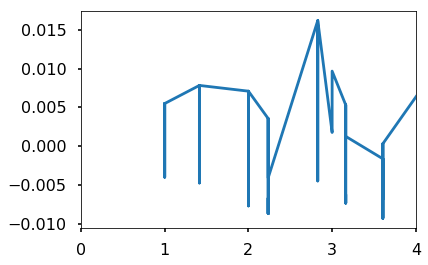

In [14]:
plt.plot(b, c)
plt.xlim([0, 4])

In [15]:
driv_m31.filters = ppy.instrument.m31_narrow_psf()
sim_m31_narrow = driv_m31.simulate(gal_m31, 1024, mag_system='ab')[1]

In [17]:
def show_corr(corr_im, ax=None, norm=None):
    if ax is None:
        fig, ax = plt.subplots()
    if norm is None:
        norm = mpl.colors.Normalize()
    ax.imshow(corr_im, interpolation='None', aspect='auto', norm=norm)
    return ax

In [18]:
m31 = fits.open('../data/m31/raw/bulge_tiny_both.fits')
m49_raw = fits.open('../data/m49/raw/oneexp_tiny_both.fits')
m49_drz = fits.open('../data/m49/raw/drizzled_tiny_both.fits')

In [19]:
m31_f475w = m31['sci,1'].data
m31_f814w = m31['sci,2'].data

Text(0.5,1,'Simulated')

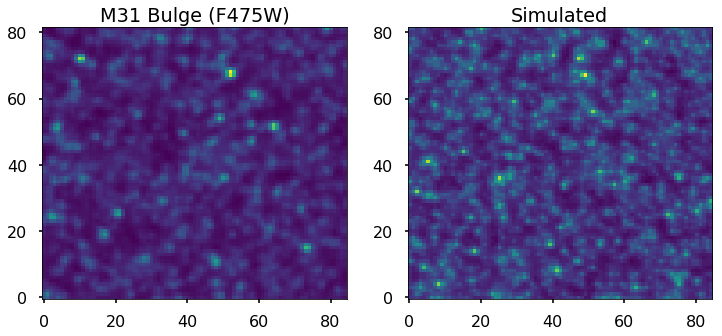

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
axes[0].imshow(m31_f475w)
axes[1].imshow(sim_m31[1][:m31_f475w.shape[0], :m31_f475w.shape[1]])
axes[0].set_title('M31 Bulge (F475W)')
axes[1].set_title('Simulated')

In [21]:
m49_f475w_raw = m49_raw['sci,1'].data
m49_f850lp_raw = m49_raw['sci,2'].data
m49_f475w_raw[np.isnan(m49_f475w_raw)] = -1.
m49_f850lp_raw[np.isnan(m49_f850lp_raw)] = -1.

In [22]:
m49_f475w_drz = m49_drz['sci,1'].data * f_m49[1]._exposure
m49_f850lp_drz = m49_drz['sci,2'].data * f_m49[0]._exposure

Text(0.5,1,'Simulated')

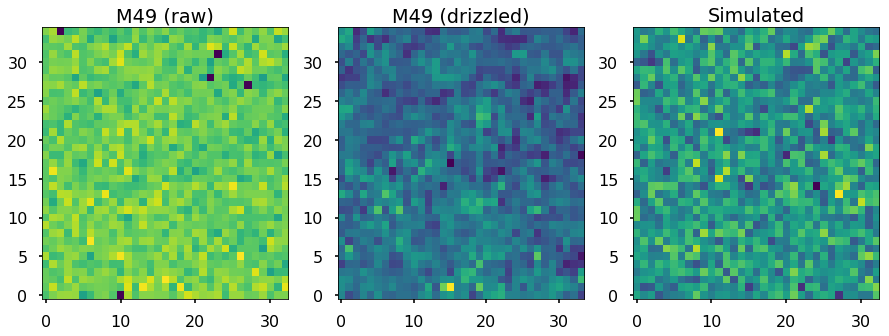

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
axes[0].imshow(m49_f475w_raw)
axes[1].imshow(m49_f475w_drz)
axes[2].imshow(sim_m49[1][:m49_f475w_raw.shape[0], :m49_f475w_raw.shape[1]])
axes[0].set_title('M49 (raw)')
axes[1].set_title('M49 (drizzled)')
axes[2].set_title('Simulated')

In [24]:
corrs, xs, ys = {}, {}, {}

In [25]:
ims = {
    'm31_f475w_drz': m31_f475w,
    'm31_f814w_drz': m31_f814w,
    'm31_f475w_sim': sim_m31[1],
    'm31_f814w_sim': sim_m31[0],
    'm31_f475w_sim_narrow': sim_m31_narrow[1],
    'm31_f814w_sim_narrow': sim_m31_narrow[0],
    'm49_f475w_raw': m49_f475w_raw,
    'm49_f475w_drz': m49_f475w_drz,
    'm49_f475w_sim': sim_m49[1],
    'm49_f850lp_raw': m49_f850lp_raw,
    'm49_f850lp_drz': m49_f850lp_drz,
    'm49_f850lp_sim': sim_m49[0],
}

In [26]:
for name, im in ims.items():
#     im /= im.mean()
    corrs[name], xs[name], ys[name] = spatial_correlation(im, a=5)

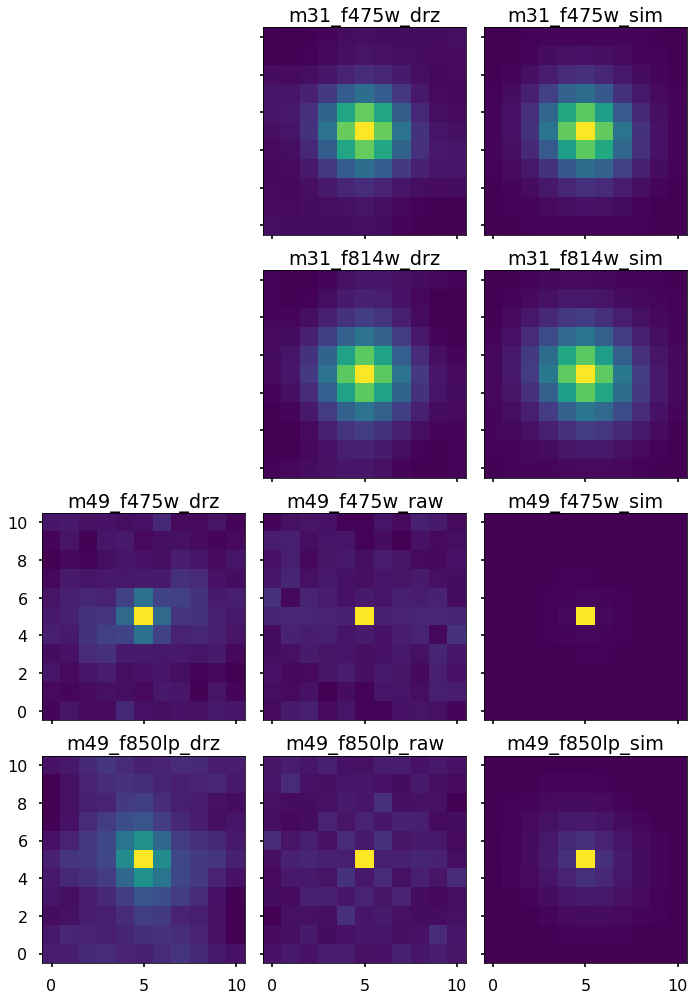

In [27]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(10, 14), sharex=True, sharey=True)
for a, n in zip(axes[0][1:], ['m31_f475w_drz', 'm31_f475w_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)
axes[0,0].axis('off')

for a, n in zip(axes[1][1:], ['m31_f814w_drz', 'm31_f814w_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)
axes[1,0].axis('off')

for a, n in zip(axes[2], ['m49_f475w_drz', 'm49_f475w_raw', 'm49_f475w_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)

for a, n in zip(axes[3], ['m49_f850lp_drz', 'm49_f850lp_raw', 'm49_f850lp_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)

plt.tight_layout()

In [28]:
palette = sns.color_palette('colorblind')

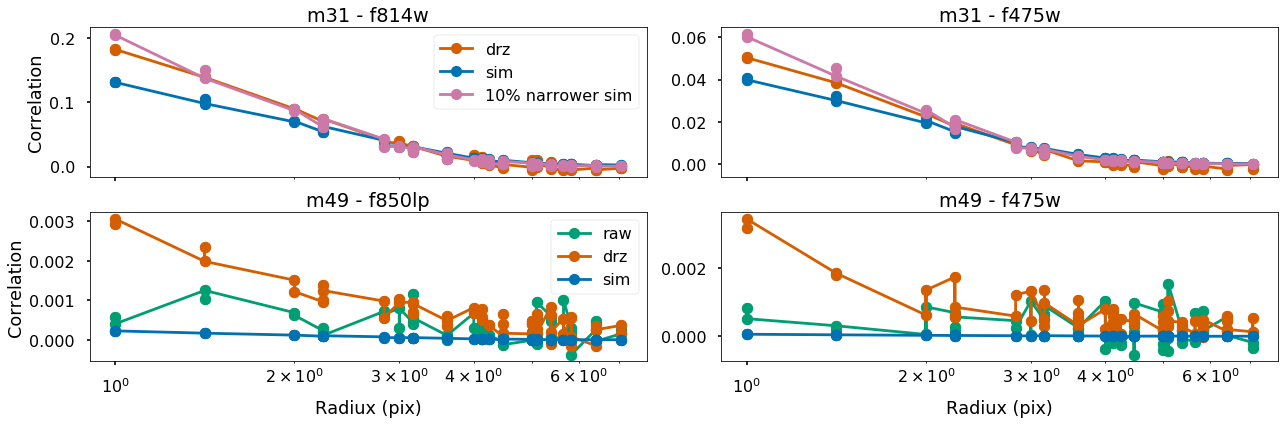

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 6), sharex=True)
for n in xs.keys():
    if 'm31' in n:
        if 'f814w' in n:
            ax = axes[0,0]
        else:
            ax = axes[0,1]
    else:
        if 'f850lp' in n:
            ax = axes[1,0]
        else:
            ax = axes[1,1]
    if 'narrow' in n:
        label='10% narrower sim'
        color = palette[3]
    elif 'sim' in n:
        label = 'sim'
        color= palette[0]
    elif 'raw' in n:
        label = 'raw'
        color = palette[1]
    else:
        label = 'drz'
        color = palette[2]
    ax.plot(xs[n], ys[n], label=label, color=color, ls='-', marker='o')
axes[0,0].set_title('m31 - f814w')
axes[0,1].set_title('m31 - f475w')
axes[1,0].set_title('m49 - f850lp')
axes[1,1].set_title('m49 - f475w')
axes[1,0].legend(loc=0)
axes[0,0].legend(loc=0)
for a in axes[1]:
    a.set_xlabel('Radiux (pix)')
for a in axes[:,0]:
    a.set_ylabel('Correlation')
for a in axes.flatten():
    a.set_xscale('log')
#     a.set_xlim(xmax=4)
#     a.set_yscale('log')
#     a.set_ylim([0.001, 1])
plt.tight_layout()

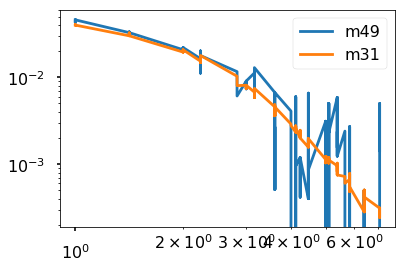

In [30]:
plt.plot(xs['m49_f475w_sim'], ys['m49_f475w_sim']*10.**(5.2-2.3), label='m49')
plt.plot(xs['m31_f475w_sim'], ys['m31_f475w_sim'], label='m31')
plt.legend(loc=0)
plt.xscale('log')
plt.yscale('log')

# Find decent PSF match

In [83]:
def narrow_f814w(alpha):
    psf = fits.open('../pcmdpy/pcmdpy/psf/ACS_WFC_F814W.fits')[0].data.astype(float)**alpha
    return ppy.instrument.ACS_WFC_F814W(exposure=3235., psf=psf)

In [84]:
def narrow_f475w(alpha):
    psf = fits.open('../pcmdpy/pcmdpy/psf/ACS_WFC_F475W.fits')[0].data.astype(float)**alpha
    return ppy.instrument.ACS_WFC_F475W(exposure=3620., psf=psf)

In [85]:
def corr_narrow(alpha, Nim=1024):
    driv_m31.filters = [narrow_f814w(alpha), narrow_f475w(alpha)]
    im_test = driv_m31.simulate(gal_m31, Nim, mag_system='ab')[1]
    corr, x1, y1 = spatial_correlation(im_test[0], a=5)
    corr, x2, y2 = spatial_correlation(im_test[1], a=5)
    return x1, y1, x2, y2

In [217]:
xs_f475w, ys_f475w = {}, {}
xs_f814w, ys_f814w = {}, {}

for alpha in tqdm(np.linspace(1.05, 1.25, 100)):
    xs_f814w[alpha], ys_f814w[alpha], xs_f475w[alpha], ys_f475w[alpha] = corr_narrow(alpha, Nim=1024)

100%|██████████| 100/100 [10:56<00:00,  6.63s/it]


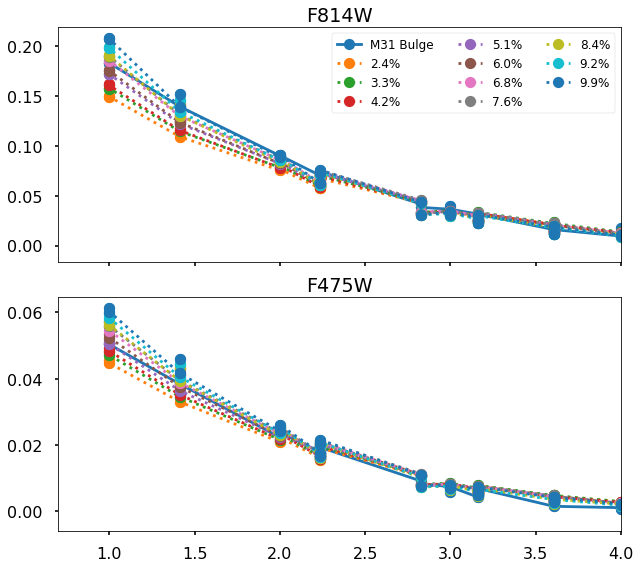

In [234]:
fig, axes = plt.subplots(nrows=2, figsize=(9, 8), sharex=True)
axes[0].plot(xs['m31_f814w_drz'], ys['m31_f814w_drz'], label='M31 Bulge', marker='o')
axes[1].plot(xs['m31_f475w_drz'], ys['m31_f475w_drz'], label='M31 Bulge', marker='o')
for k in sorted(xs_f814w.keys())[::10]:
    d_sig = 100.*(1. - (1./np.sqrt(k)))
    axes[0].plot(xs_f814w[k], ys_f814w[k], label='{:.1f}%'.format(d_sig), marker='o', ls=':')
    axes[1].plot(xs_f475w[k], ys_f475w[k], label='{:.1f}%'.format(d_sig), marker='o', ls=':')
axes[0].set_title('F814W')
axes[1].set_title('F475W')
axes[0].legend(loc=0, ncol=3, fontsize=12)
axes[0].set_xlim(xmax=4)
plt.tight_layout()

In [219]:
def group(x, y, xmax=3.0):
    x_, y_, y_err = [], [], []
    for i in sorted(np.unique(x)):
        if i > xmax:
            break
        x_.append(i)
        ys = y[x == i]
        y_.append(np.mean(ys))
        y_err.append(np.std(ys))
    return np.array(x_), np.array(y_), np.array(y_err)

In [220]:
def loglike(x1, y1, x2, y2):
    x1, y1, yerr1 = group(x1, y1)
    x2, y2, yerr2 = group(x2, y2)
    assert np.all(x1 == x2)
    return normal.logpdf(y2, loc=y1, scale=np.sqrt(yerr1**2 + yerr2**2)).sum()

In [221]:
ll_f475w, ll_f814w = {}, {}
for k in xs_f475w.keys():
    ll_f475w[k] = loglike(xs['m31_f475w_drz'], ys['m31_f475w_drz'], xs_f475w[k], ys_f475w[k])
    ll_f814w[k] = loglike(xs['m31_f814w_drz'], ys['m31_f814w_drz'], xs_f814w[k], ys_f814w[k])

In [222]:
def alpha_to_percent(alpha):
    return 100.*(1. - (1./np.sqrt(alpha)))

In [223]:
ll_f475w = pd.DataFrame(data=list(ll_f475w.values()), index=np.round(list(ll_f475w.keys()), 3), columns=['ll_f475w'])
ll_f814w = pd.DataFrame(data=list(ll_f814w.values()), index=np.round(list(ll_f814w.keys()), 3), columns=['ll_f814w'])

In [225]:
ll_f475w['ll_f814w'] = ll_f814w.loc[ll_f475w.index]
ll_f475w['alpha'] = ll_f475w.index
ll_f475w['sig'] = alpha_to_percent(ll_f475w.index)

In [230]:
ll = ll_f475w.sort_index()
ll.head()

,ll_f475w,ll_f814w,alpha,sig
1.050,-47.978533,-8601.733111,1.050,2.409993
1.052,-41.220715,-14115.773785,1.052,2.502803
1.054,-21.799154,-4304.159445,1.054,2.595349
1.056,-19.090884,-3333.690218,1.056,2.687632
1.058,-25.084118,-7413.186114,1.058,2.779653


In [231]:
ll.ix[ll.ll_f475w.idxmax()]

/n/home01/bcook/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


ll_f475w     34.164209
ll_f814w   -616.580448
alpha         1.109000
sig           5.041417
Name: 1.109, dtype: float64

In [232]:
ll.ix[ll.ll_f814w.idxmax()]

ll_f475w     9.126067
ll_f814w    10.952763
alpha        1.147000
sig          6.627650
Name: 1.147, dtype: float64

(-1000, 100)

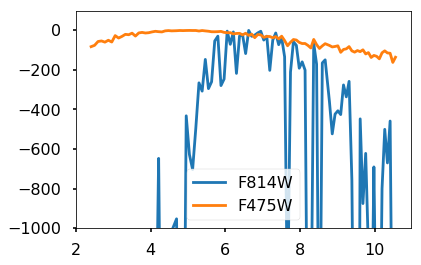

In [233]:
plt.plot(ll.sig, ll.ll_f814w-np.max(ll.ll_f814w), label='F814W')
plt.plot(ll.sig, ll.ll_f475w-np.max(ll.ll_f475w), label='F475W')
plt.legend(loc=0)
plt.ylim([-1000, 100])

In [243]:
xs_f475w.keys()

dict_keys([1.05, 1.052020202020202, 1.054040404040404, 1.0560606060606061, 1.0580808080808082, 1.0601010101010102, 1.0621212121212122, 1.0641414141414143, 1.0661616161616163, 1.0681818181818181, 1.0702020202020202, 1.0722222222222222, 1.0742424242424242, 1.0762626262626263, 1.0782828282828283, 1.0803030303030303, 1.0823232323232324, 1.0843434343434344, 1.0863636363636364, 1.0883838383838385, 1.0904040404040405, 1.0924242424242425, 1.0944444444444446, 1.0964646464646466, 1.0984848484848486, 1.1005050505050504, 1.1025252525252525, 1.1045454545454545, 1.1065656565656565, 1.1085858585858586, 1.1106060606060606, 1.1126262626262626, 1.1146464646464647, 1.1166666666666667, 1.1186868686868687, 1.1207070707070708, 1.1227272727272728, 1.1247474747474748, 1.1267676767676769, 1.128787878787879, 1.130808080808081, 1.132828282828283, 1.1348484848484848, 1.1368686868686868, 1.1388888888888888, 1.1409090909090909, 1.142929292929293, 1.144949494949495, 1.146969696969697, 1.148989898989899, 1.1510101010

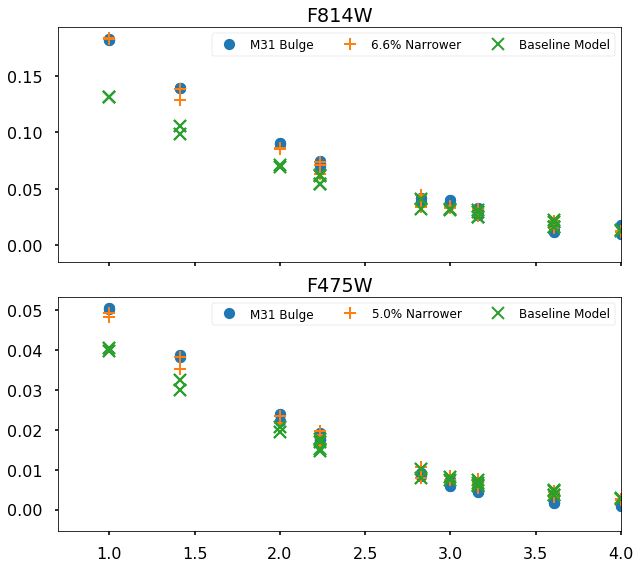

In [253]:
fig, axes = plt.subplots(nrows=2, figsize=(9, 8), sharex=True)
axes[0].plot(xs['m31_f814w_drz'], ys['m31_f814w_drz'], label='M31 Bulge', marker='o', ls='')
axes[1].plot(xs['m31_f475w_drz'], ys['m31_f475w_drz'], label='M31 Bulge', marker='o', ls='')
axes[0].plot(xs_f814w[1.146969696969697], ys_f814w[1.146969696969697], label='{:.1f}% Narrower'.format(6.63), marker='+', ls='', mew=2)
axes[1].plot(xs_f475w[1.0904040404040405], ys_f475w[1.0904040404040405], label='{:.1f}% Narrower'.format(5.04), marker='+', ls='', mew=2)
axes[0].plot(xs['m31_f814w_sim'], ys['m31_f814w_sim'], label='Baseline Model', marker='x', ls='', mew=2)
axes[1].plot(xs['m31_f475w_sim'], ys['m31_f475w_sim'], label='Baseline Model', marker='x', ls='', mew=2)
axes[0].set_title('F814W')
axes[1].set_title('F475W')
axes[0].legend(loc=0, ncol=3, fontsize=12)
axes[1].legend(loc=0, ncol=3, fontsize=12)
axes[0].set_xlim(xmax=4)
plt.tight_layout()